# Data Pre-processing
- Import libs: pandas, numpy, sklearn, seaborn, matplotlib

In [49]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = [16, 9]
sns.set(rc={'figure.figsize':(16, 9)})

## Read data from file
 - Read file 'TRINH_KHA.csv' and display data type

In [50]:
data = pd.read_csv("../data/VNPT_TH.csv")
data.dtypes

time      object
SO2      float64
CO       float64
NH3      float64
O3       float64
PM25     float64
PM10     float64
AQI      float64
CO2      float64
PM01     float64
TVOC     float64
TEMP     float64
HUM      float64
LIGHT    float64
node      object
dtype: object

- Display 10 first records

In [51]:
data.head(10)

time   SO2   CO  NH3    O3  PM25  PM10   AQI    CO2  PM01  \
0  2018-09-01 00:00:00   NaN  NaN  NaN   NaN   NaN   NaN   NaN  685.0   2.0   
1  2018-09-01 00:00:42  66.1  0.0  2.4  17.6   8.3   1.9  66.1  422.0   1.0   
2  2018-09-01 00:01:25  64.8  0.0  1.5  17.6   8.3   1.9  64.8  529.0   1.0   
3  2018-09-01 00:02:08  63.6  0.0  1.7  17.6   8.3   1.9  63.6  687.0   1.0   
4  2018-09-01 00:02:51  63.6  0.0  2.3  17.6  12.5   2.8  63.6  677.0   2.0   
5  2018-09-01 00:03:34  63.6  0.0  1.7  16.7   8.3   1.9  63.6  603.0   1.0   
6  2018-09-01 00:04:17  63.6  0.0  1.5  17.6   8.3   1.9  63.6  494.0   1.0   
7  2018-09-01 00:05:00  63.6  0.0  1.5  17.6   4.2   0.9  63.6  468.0   1.0   
8  2018-09-01 00:05:43  64.8  0.0  1.6  17.6   4.2   1.9  64.8  689.0   0.0   
9  2018-09-01 00:06:26  64.8  0.0  1.7  17.6   8.3   1.9  64.8  511.0   0.0   

   TVOC  TEMP   HUM  LIGHT        node  
0   5.0  25.7  25.5    0.0  TT_VNPT_TH  
1   4.0  25.7  25.0    0.0  TT_VNPT_TH  
2   4.0  25.7  24.5    0.0  TT_VNPT_TH  
3   1.0  25.7  24.2    0.0  TT_VNPT_TH  
4   2.0  25.6  23.7    0.0  TT_VNPT_TH  
5   1.0  25.6  23.4    0.0  TT_VNPT_TH  
6   5.0  25.6  24.1    0.0  TT_VNPT_TH  
7   6.0  25.5  24.6    0.0  TT_VNPT_TH  
8   1.0  25.6  25.3    0.0  TT_VNPT_TH  
9   1.0  25.5  26.0    0.0  TT_VNPT_TH

## Remove NaN, outliers and unnecessary columns: SO2, CO, NH3, PM25, PM01, AQI, TVOC

In [52]:
date_time = pd.to_datetime(data['time'])
data['time'] = date_time
data = data.drop(['SO2', 'CO', 'NH3', 'O3', 'AQI', 'PM01', 'TVOC'], axis=1)
data = data.dropna(axis=0)
data = data.drop(data[data.LIGHT >= 1000].index)

# data.describe()

## Generate features and labels
- List of all features:
    - **f1**: Month
    - **f2**: Day of week
    - **f3**: Hour
    - **f4**: Current PM10 AQI value
    - **f5**: Current CO2 concentration
    - **f6**: Current temperature
    - **f7**: Current humidity
    - **f8**: Current illuminance
    - **f9 → f33**: PM10 AQI value from 1 to 24 hour ago
    - **f34**: maximum PM10 AQI value in last 24 hours
    - **f35**: minimum PM10 AQI value in last 24 hours
    - **f36**: average PM10 AQI value in last 24 hours
    - **f37**: maximum temperature in last 24 hours
    - **f38**: minimum temperature in last 24 hours
    - **f39**: average temperature in last 24 hours
    - **f40**: maximum humidity in last 24 hours
    - **f41**: minimum humidity in last 24 hours
    - **f42**: average humidity in last 24 hours
- Label: Next PM10 AQI value

### Create <i>Month</i>, <i>Day of week</i>, <i>Hour</i> features from time column.

In [53]:
times = pd.DatetimeIndex(data.time)
data = data.groupby([times.month, times.day, times.dayofweek, times.hour, pd.Grouper(key='time',freq='1800s')]).mean(numeric_only=True)
data.index.names = ["Month", "Day", "DayOfWeek", "Hour", "Minute"]
data.index = data.index.droplevel(1)
# data.index.values

Text(0.5, 1.0, 'PM25 histogram')

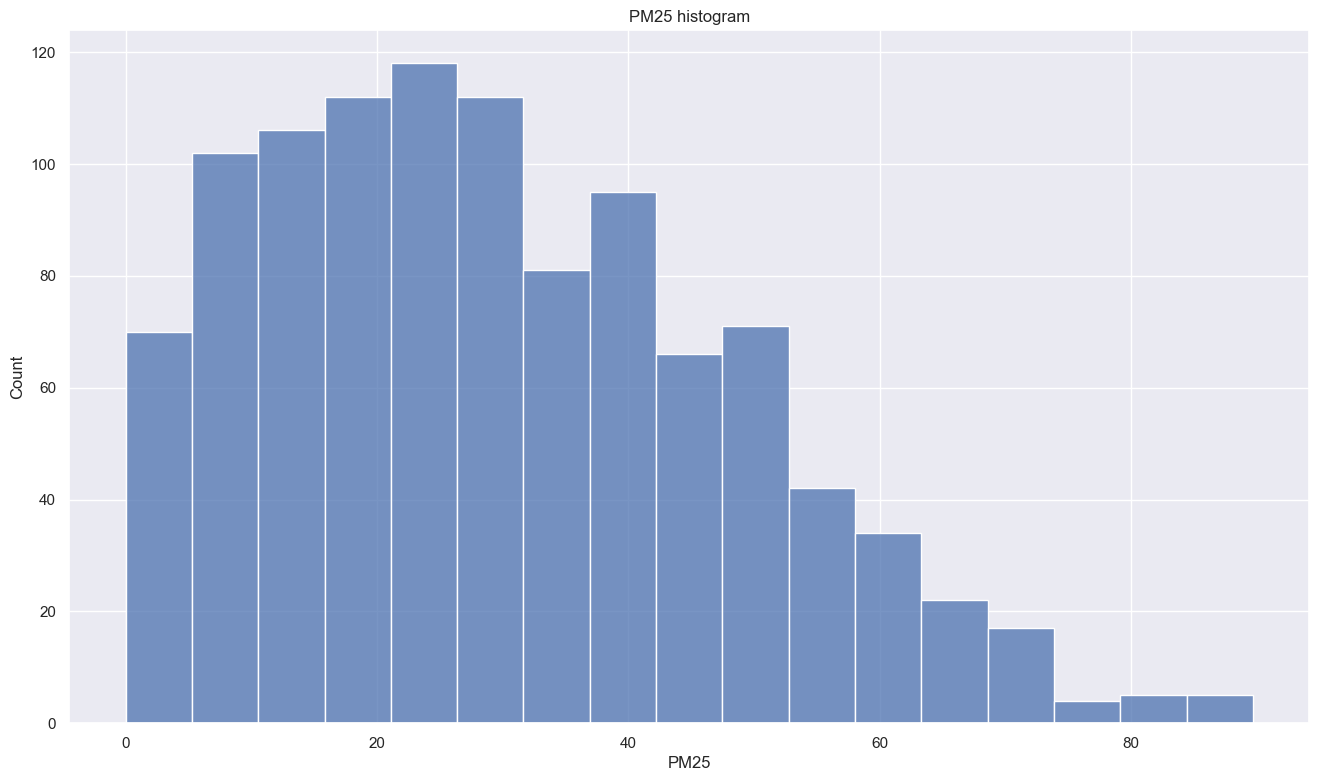

In [54]:
sns.histplot(data["PM25"]).set_title("PM25 histogram")

<Axes: xlabel='Month,DayOfWeek,Hour,Minute'>

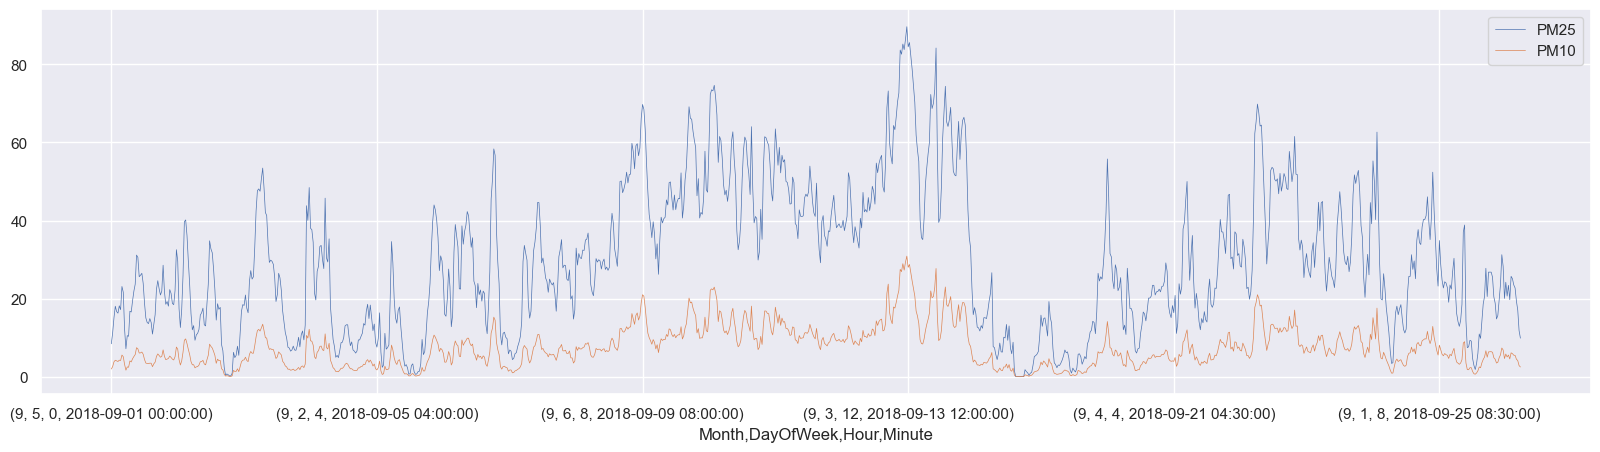

In [55]:
data[["PM25", "PM10"]].plot(linewidth=0.5, figsize=(20, 5))

### Generate features f10 → f34

In [56]:
PM25_cols = []
TEMP_cols = []
HUM_cols = []

for i in range(1, 49):
    if i % 2 == 1:
        col = 'PM25P' + str(int(i/2)+1)
        PM25_cols.append(col)
        data[col] = data['PM25'].shift(periods=i+1)
    
    col = 'TEMPP' + str(i)
    TEMP_cols.append(col)
    data[col] = data['TEMP'].shift(periods=i)
    
    col = 'HUMP' + str(i)
    HUM_cols.append(col)
    data[col] = data['HUM'].shift(periods=i)
    
data["MAXPM10"] = data[PM25_cols].max(axis=1)
data["MINPM10"] = data[PM25_cols].min(axis=1)
data["AVGPM10"] = data[PM25_cols].mean(axis=1)

data["MAXTEMP"] = data[TEMP_cols].max(axis=1)
data["MINTEMP"] = data[TEMP_cols].min(axis=1)
data["AVGTEMP"] = data[TEMP_cols].mean(axis=1)

data["MAXHUM"] = data[HUM_cols].max(axis=1)
data["MINHUM"] = data[HUM_cols].min(axis=1)
data["AVGHUM"] = data[HUM_cols].mean(axis=1)

data = data.drop(TEMP_cols, axis=1)
data = data.drop(HUM_cols, axis=1)

C:\Users\hungn\AppData\Local\Temp\ipykernel_4368\563709798.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col] = data['HUM'].shift(periods=i)
C:\Users\hungn\AppData\Local\Temp\ipykernel_4368\563709798.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col] = data['PM25'].shift(periods=i+1)
C:\Users\hungn\AppData\Local\Temp\ipykernel_4368\563709798.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider join

### Generate labels

In [57]:
data['Label'] = data['PM25'].shift(periods=-1)


### Remove rows having NaN value

In [58]:
data = data.dropna(axis=0)
columns = data.index.names
columns = np.append(columns, data.columns.values[:-1])
date_time_values = np.asmatrix([list(item) for item in data.index.values])
data = np.append(date_time_values, data.to_numpy(), axis=1)
data[:, 3] = np.asmatrix([item[0, 0].minute for item in data[:, 3]]).T

# np.savetxt("VNPT_TH_DATA.csv", data, delimiter=",")

# Run and evaluate algorithms

## Prepare data and matplotlib plot
- Normalize data

In [59]:
# Min-Max Normalization
# scaler = preprocessing.MinMaxScaler()
# Z-Score Normalization
scaler = preprocessing.StandardScaler()

data = np.asarray(data)
data = scaler.fit_transform(data)
data

array([[ 0.        ,  1.61762092, -1.66683603, ...,  0.58513283,
         0.90429441,  0.11725582],
       [ 0.        ,  1.61762092, -1.66683603, ...,  0.58513283,
         0.93642916, -0.03744435],
       [ 0.        ,  1.61762092, -1.52084737, ...,  0.58513283,
         0.96157338, -0.68685479],
       ...,
       [ 0.        , -0.40853054,  0.23101661, ..., -0.41422268,
        -0.58886002, -0.70781171],
       [ 0.        , -0.40853054,  0.37700528, ..., -0.41422268,
        -0.56970965, -0.98888844],
       [ 0.        , -0.40853054,  0.37700528, ..., -0.41422268,
        -0.55911551, -1.09207268]])

- **y**: label is last column

In [60]:
y = data[:,-1]
X = data[:,:-1]

- Train set (75%) and test set (25%) are chosen randomly from data 

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1000)

## Multi-layer Perceptron

In [62]:
mlp = MLPRegressor(activation='logistic', hidden_layer_sizes=(100, 100,))
mlp.fit(X_train, y_train)

mlp_score = mlp.score(X_test, y_test)
print("MLP regression score: {:.4f}".format(mlp_score))

nnr_pred = mlp.predict(X_test)

MLP regression score: 0.9010


Root mean squared error: 0.3281
Mean absolute error: 0.2445
R-squared: 0.9010


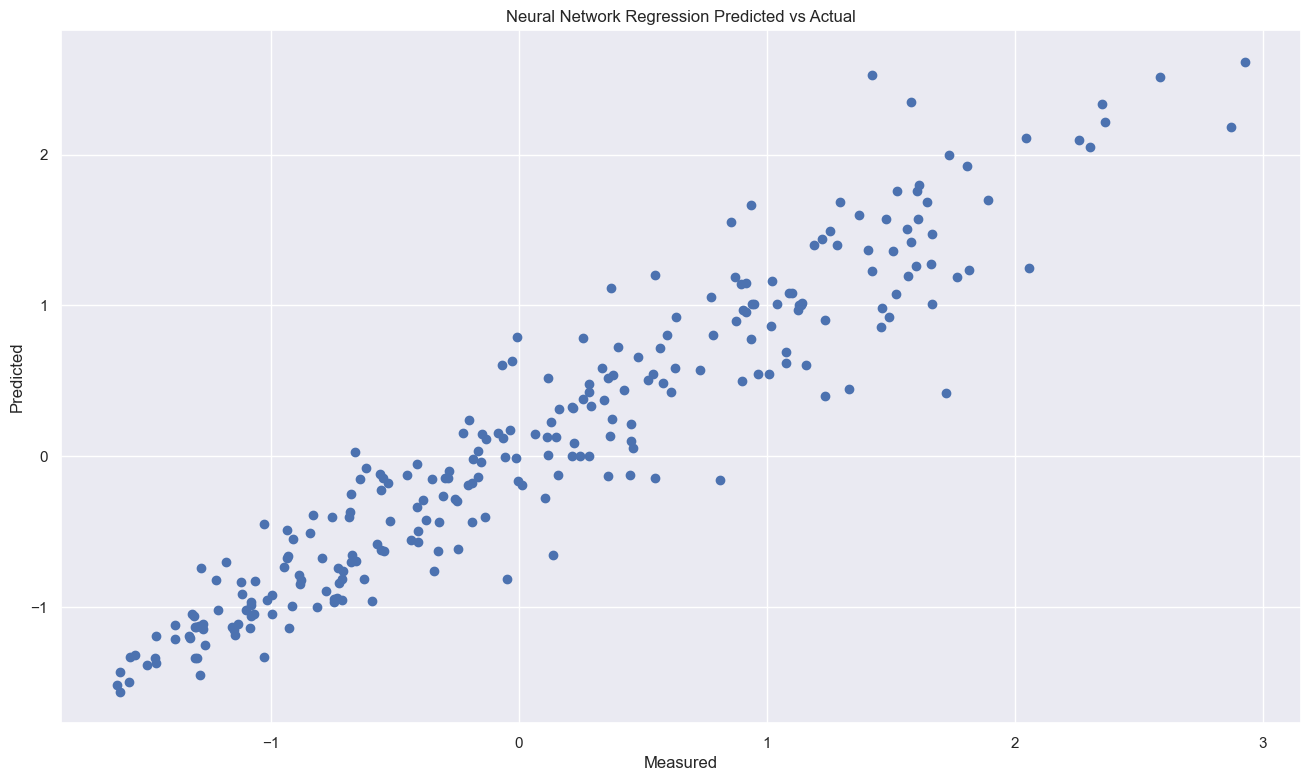

In [63]:
# The mean squared error
print("Root mean squared error: {:.4f}".format(np.sqrt(mean_squared_error(y_test, nnr_pred))))

# The absolute squared error
print("Mean absolute error: {:.4f}".format(mean_absolute_error(y_test, nnr_pred)))

# Explained variance score: 1 is perfect prediction
print("R-squared: {:.4f}".format(r2_score(y_test, nnr_pred)))


plt.scatter(y_test, nnr_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Neural Network Regression Predicted vs Actual')
plt.show()

## Decision Forest Regression

In [64]:
rf_regression = RandomForestRegressor(n_estimators=200, random_state=1234)
rf_regression.fit(X_train, y_train)

rf_score = rf_regression.score(X_test, y_test)
print("Random forest regression score: {:.4f}".format(rf_score))

rf_pred = rf_regression.predict(X_test)

Random forest regression score: 0.8841


In [65]:
# The mean squared error
print("Root mean squared error: {:.4f}".format(np.sqrt(mean_squared_error(y_test, rf_pred))))

# The absolute squared error
print("Mean absolute error: {:.4f}".format(mean_absolute_error(y_test, rf_pred)))

# Explained variance score: 1 is perfect prediction
print("R-squared: {:.4f}".format(r2_score(y_test, rf_pred)))

Root mean squared error: 0.3550
Mean absolute error: 0.2667
R-squared: 0.8841


- Display how important features are

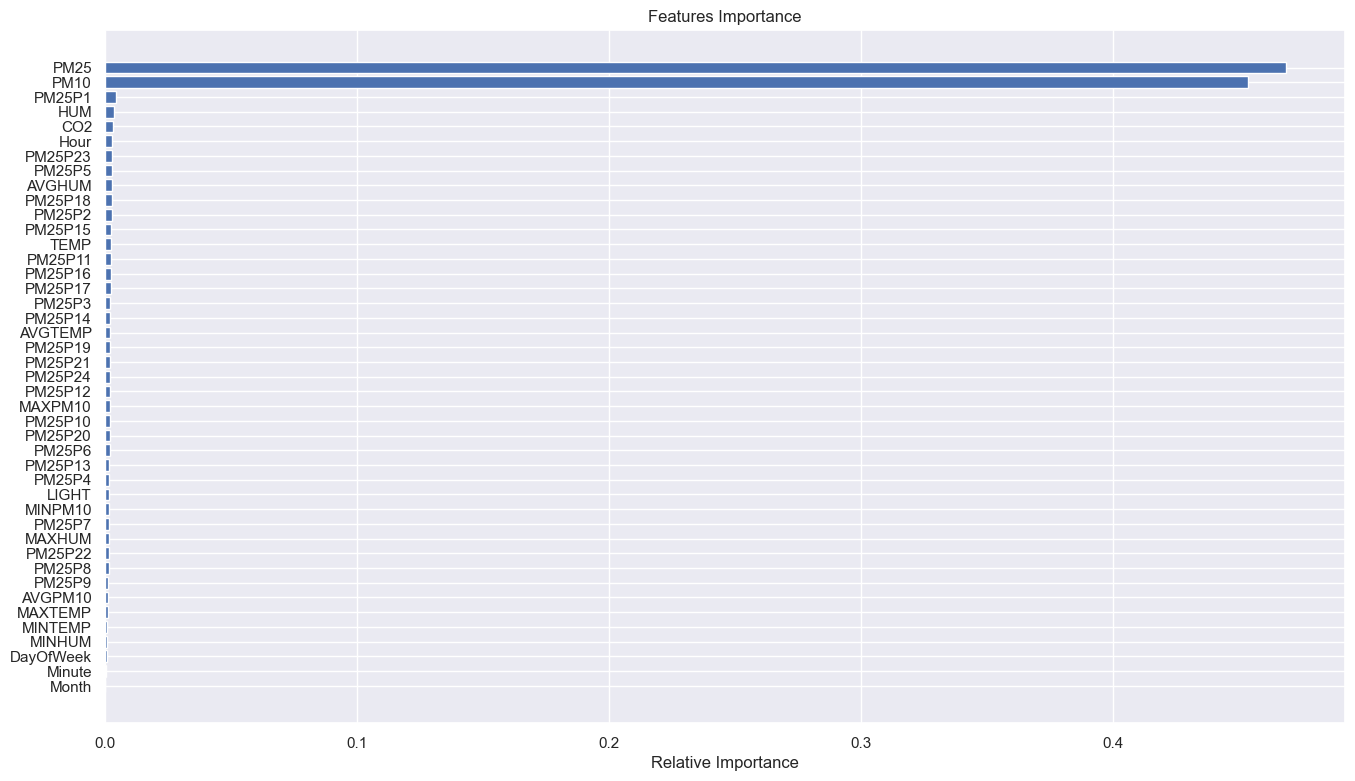

In [66]:
features = columns
importance = rf_regression.feature_importances_
indices = np.argsort(importance)

plt.title('Features Importance')
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

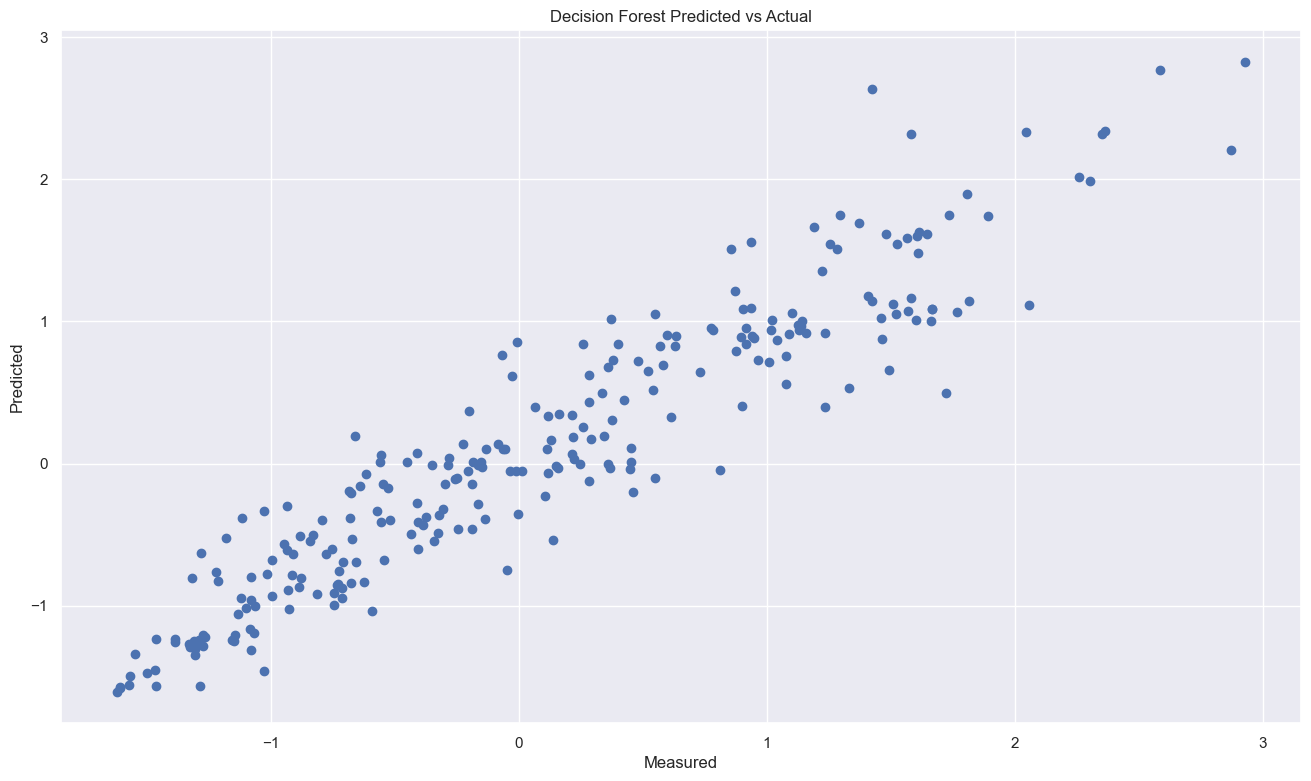

In [67]:
plt.scatter(y_test, rf_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Decision Forest Predicted vs Actual')
plt.show()